Inspired from M.Pedersen's [tutorial](https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/11_Adversarial_Examples.ipynb) (also in [video](https://www.youtube.com/watch?v=Iwei8Lah0h8)), this time using Keras and ResNet50.

We can first import a `ResNet50` pre-trained model.

In [1]:
from keras.applications.resnet50 import ResNet50

model = ResNet50(weights='imagenet', include_top=True)

Using TensorFlow backend.


Importing class names from [ResNet50's object](https://github.com/keras-team/keras/blob/master/keras/applications/imagenet_utils.py)

In [0]:
from keras.applications import imagenet_utils
from keras.utils.data_utils import get_file
import json

def get_imagenet_classes():
    CLASS_INDEX_PATH = 'https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json'
    fpath = get_file('imagenet_class_index.json', CLASS_INDEX_PATH, 
                     file_hash='c2c37ea517e94d9795004a39431a14cb')
    with open(fpath) as f:
        return [values[1] for key, values in json.load(f).items()]

class_indexes = get_imagenet_classes()

Few helper functions to: load, pre-process, print top n prediction and get a specific class prediction

In [0]:
from keras.preprocessing import image as image_
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
from PIL import Image

def load_image(image_path=None, image_url=None, new_size=None):
    if(image_path is not None):
      img = image.load_img(image_path, target_size=new_size)
    elif(image_url is not None):
      from PIL import Image
      import requests
      import urllib.request
      from io import BytesIO
      fd = urllib.request.urlretrieve(image_url, "tmp.jpg")
      im1 = Image.open("tmp.jpg")    
      img = im1.resize(new_size, Image.ANTIALIAS)
                   
    return img

def process_image(image):
    x = np.expand_dims(image_.img_to_array(image), axis=0)
    x = preprocess_input(x, data_format=None, mode='caffe')
    return x
  
def get_predictions(predictions, top=3):
    if(top is 1):
      return decode_predictions(predictions, top=1)[0][0][1:]
    else:
      return decode_predictions(predictions, top=top)[0]
    
def get_class_probability(predictions, target_name, class_names=class_indexes):
    try:
        index = class_names.index(target_name)
        return predictions[0][index]
    except ValueError:
        return None

def rebuild_image(x_, as_np_array=False):
  x = x_.copy()
  mean = [103.939, 116.779, 123.68]
  x[..., 0] += mean[0]
  x[..., 1] += mean[1]
  x[..., 2] += mean[2]
  x = x[..., ::-1]
  x = x.astype(np.uint16)
  if(as_np_array):
    return x
  else:
    return image_.array_to_img(x)

Downloading an image. I choose three differents images:

- One with strong components in the red and blue component: a frog
- One with some white pixels (ie, RGB=(255,255,255)): alpe mountain
- One random: a dog

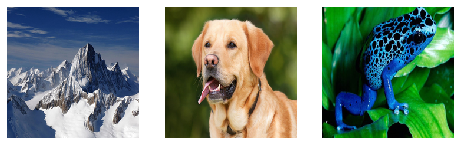

In [5]:
import matplotlib.pyplot as plt

url_snow = 'https://upload.wikimedia.org/wikipedia/commons/thumb/5/51/Finsteraarhorn_and_surrounding_mounts.jpg/1280px-Finsteraarhorn_and_surrounding_mounts.jpg'
url_blue_green_frog = 'http://1papernews.xyz/wp-content/uploads/2017/02/1-6-592x370.jpg'
url_dog = "https://i2.wp.com/manipulatori.cz/wp-content/uploads/2016/05/dog-1210559_960_720.jpg?w=960"
frog = load_image(image_url= url_blue_green_frog, new_size=(224, 224))
dog = load_image(image_url= url_dog, new_size=(224, 224))
snow = load_image(image_url= url_snow, new_size=(224, 224))

plt.figure(1)

plt.subplot(131)
plt.imshow(snow)
plt.tick_params(axis='both', which='both', bottom='off', top='off', 
                 labelbottom='off', right='off', left='off', labelleft='off')
plt.grid(False)

plt.subplot(132)
plt.imshow(dog)
plt.tick_params(axis='both', which='both', bottom='off', top='off', 
                 labelbottom='off', right='off', left='off', labelleft='off')
plt.grid(False)

plt.subplot(133)
plt.imshow(frog)
plt.tick_params(axis='both', which='both', bottom='off', top='off', 
                 labelbottom='off', right='off', left='off', labelleft='off')
plt.grid(False)

In [7]:
target_class = "plane"

def basic_predictions(model, image, target_class):
  processed_image = process_image(image)
  predictions = model.predict(processed_image)
  original_prediction = get_predictions(predictions, top=1)
  target_class_prediction = get_class_probability(predictions, target_class)
  info = "Image recognised as a(n) {0} with confidence {1:.2}, "\
         "target class {2} with confidence {3:.2}"
  print(info.format(original_prediction[0], 
                    original_prediction[1], 
                    target_class, 
                    target_class_prediction))
  
basic_predictions(model, frog, target_class)
basic_predictions(model, dog, target_class)
basic_predictions(model, snow, target_class)

Image recognised as a(n) tailed_frog with confidence 0.85, target class plane with confidence 1.3e-08
Image recognised as a(n) golden_retriever with confidence 0.81, target class plane with confidence 2.6e-07
Image recognised as a(n) alp with confidence 0.93, target class plane with confidence 1.2e-08


## Generating adversarial noise

In [0]:
def plot_image_only(ax, image, title=''):
  ax.imshow(image)
  ax.grid(False)
  ax.tick_params(axis='both', which='both', bottom='off', top='off', 
                 labelbottom='off', right='off', left='off', labelleft='off')
  ax.set_title(title)

def plot_adversarial(model, adversarial_image, added_noise, original_image, 
                     amplify_noise = 10,
                     process_image=process_image):
  title = "image {0} (confidence score: {1:.4})"
  
  fig = plt.figure(figsize=(12,12))
  ax = fig.add_subplot(221)
  original_prediction = get_predictions(model.predict(process_image(original_image)), top=1)
  plot_image_only(ax, original_image, ("Original "+title).format(original_prediction[0], 
                                                                 original_prediction[1]))

  ax = fig.add_subplot(222)
  noise = rebuild_image((added_noise[0] - added_noise[0].min()) * amplify_noise)
  plot_image_only(ax, noise, "Amplified noise (x{0})".format(amplify_noise))

  ax = fig.add_subplot(223)
  adversarial_prediction = get_predictions(model.predict(adversarial_image), top=1)
  adversarial = rebuild_image(adversarial_image[0])
  plot_image_only(ax, adversarial, ("Adversarial "+title).format(adversarial_prediction[0], 
                                                                 adversarial_prediction[1]))

In [0]:
from keras import backend as K
# got some code from this great post on medium.com/@ageitgey/machine-learning-is-fun-part-8-how-to-intentionally-trick-neural-networks-b55da32b7196

def find_adversial_image(model, target_class, image, minimal_cost=0.8, 
                         noise_clip=(-3,3), factor_step=5, 
                         log_progression=True, max_iteration=500,
                         plot_result_function=plot_adversarial,
                         plot_result=True):
  model_output_layer = model.layers[-1].output
  model_input_layer = model.layers[0].input
  
  target_class_id = class_indexes.index(target_class)
  cost_function = model_output_layer[0, target_class_id]
  gradient_input_output = K.gradients(cost_function, model_input_layer)[0]
  get_cost_gradient = K.function([model_input_layer, K.learning_phase()], [cost_function, gradient_input_output])
  
  log = "#{0} predicted likelihood for {2} is {1:.4}%"
  noise = np.zeros(process_image(image).shape)
  np_image = image_.img_to_array(image)
  
  for i in range(max_iteration):
      noisy_image = np.clip(np_image + noise[0], 0, 255)
      noisy_image = process_image(noisy_image)

      cost, gradients = get_cost_gradient([noisy_image, 0])
      
      if(cost >= minimal_cost):
        print("break@", log.format(i, cost * 100, target_class))
        break
        
      if(log_progression and i % 15 == 0):
        print(log.format(i, cost * 100, target_class))
        
      grad_absmax = np.abs(gradients).max()
      if grad_absmax < 1e-10:
          grad_absmax = 1e-10
      
      step_size = factor_step / grad_absmax
      noise += gradients * step_size
      noise = np.clip(noise, noise_clip[0], noise_clip[1])

  if(plot_result):
    plot_result_function(model, noisy_image, noise, image)
        
  return noisy_image, noise, image

## correction

#0 predicted likelihood for plane is 2.573e-05%
#15 predicted likelihood for plane is 7.962%
break@ #27 predicted likelihood for plane is 99.06%


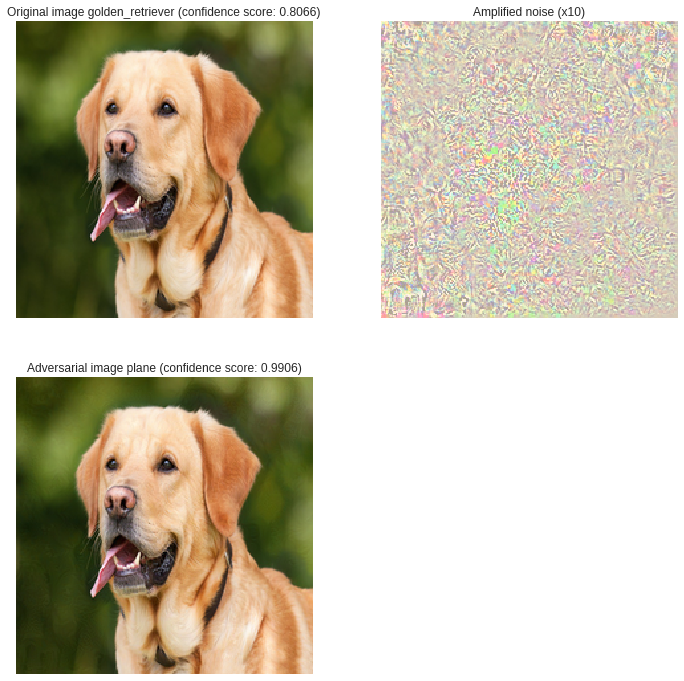

In [18]:
_,_,_, = find_adversial_image(model=model, 
                     image=dog, 
                     target_class=target_class,
                     minimal_cost=0.99)

#0 predicted likelihood for plane is 1.194e-06%
#15 predicted likelihood for plane is 70.62%
break@ #21 predicted likelihood for plane is 99.51%


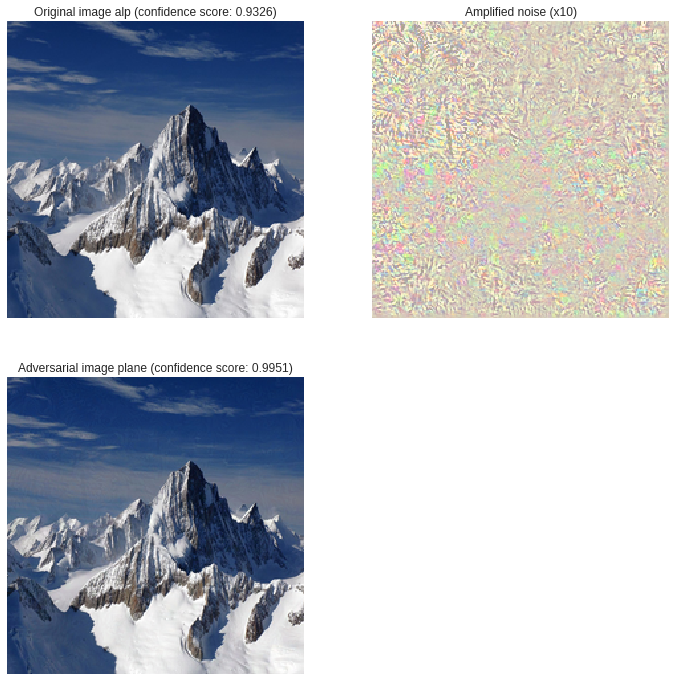

In [13]:
_,_,_, = find_adversial_image(model=model, 
                     image=snow, 
                     target_class=target_class,
                     minimal_cost=0.99)

#0 predicted likelihood for plane is 1.332e-06%
break@ #15 predicted likelihood for plane is 99.66%


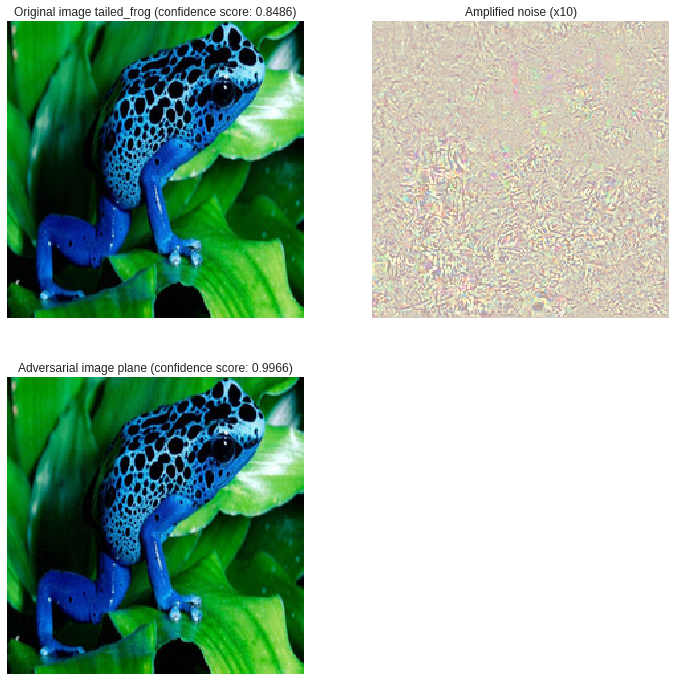

In [14]:
adversarial_frog, adversarial_noise_frog,_ = find_adversial_image(model=model, 
                     image=frog, 
                     target_class=target_class,
                     minimal_cost=0.99)

Bonus: we input a black image and choose to target the 'banjo' class.

#0 predicted likelihood for banjo is 0.007987%
#15 predicted likelihood for banjo is 66.04%
break@ #18 predicted likelihood for banjo is 93.77%


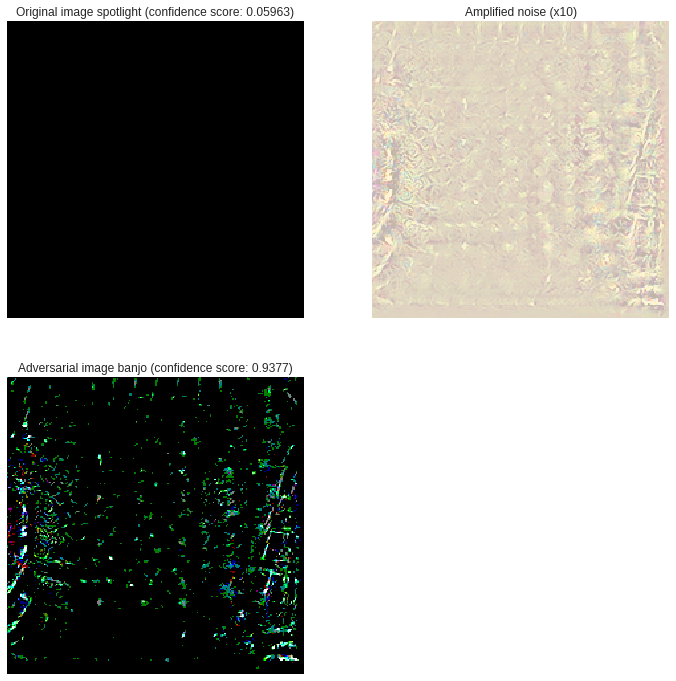

In [15]:
adversarial_frog, adversarial_noise_frog,_ = find_adversial_image(model=model, 
                     image=np.zeros((224,224,3)), 
                     target_class="banjo",
                     minimal_cost=0.9,
                     noise_clip=(-2,2))

Let's come back with the frog. We can try to blur the adversarial image in order to cancel the noise. But it won't correctly classify our image

In [16]:
from scipy import ndimage
from scipy import misc

blurred_adversarial_frog = ndimage.gaussian_filter(rebuild_image(adversarial_frog[0]), sigma=1)
predictions = model.predict(process_image(blurred_adversarial_frog))
get_predictions(predictions)

[('n03388043', 'fountain', 0.05666038),
 ('n01773549', 'barn_spider', 0.051836845),
 ('n04548362', 'wallet', 0.03691612)]

Since the noise is small, a better strategy would be to lower the bit-depth of the input image.